In [9]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v2')

100%|██████████| 504M/504M [01:57<00:00, 4.27MB/s]   


In [3]:
path = "./book-json/"

In [7]:
import json
import re

def preprocessing(input_path):
    with open(path + input_path, encoding='utf-8') as json_file:
        json_data = json.load(json_file)
    
    # 본문
    title = json_data["title"]
    texts = json_data["texts"]

    # 문장별로 잘려서 들어가있는 본문
    splitted_text = list()

 

    split = False
    split_sentence = ""
    for i in range(len(texts)):
        page = int(texts[i]["page"])
        text = texts[i]["text"]
        if text[-2] not in ["?", ".", "!", "\n"]: # 문장이 끊겨 있으면
            split_n = True
            end = -1
        else :
            split_n = False
            end = 0
            
        text = re.sub("[^ ㄱ-ㅣ가-힣0-9a-zA-Z\.|\?|\!|\n]+", "", text)
        sents = re.split(r"[\?|\.|\!|\n]", text)
        
        if split :
            splitted_text.append(split_sentence + sents[0])
            start = 1
            split = False
        else : start = 0
        
        if split_n :
            split_sentence = sents[-1]
            
        split = split_n
        
      
        for i in range(start, len(sents) + end):
            if sents[i] == "f ":
                pass
            elif sents[i] == None:
                pass
            elif sents[i] == "\n":
                pass
            elif sents[i] == "":
                pass
            elif sents[i] == " ":
                pass
            else:
                splitted_text.append(sents[i])

    for i in range(len(splitted_text)):
        if splitted_text[i][0] == " ":
            splitted_text[i] = splitted_text[i][1:]


    return title, splitted_text

In [8]:
title, full_text = preprocessing("기드모파상_비계덩어리.json")
title2, full_text2 = preprocessing("강신재_해방촌가는길.json")

In [22]:
full_text = full_text + full_text2
title = title + "+" + title2

In [23]:
embeddings = model.encode(full_text, show_progress_bar=True)

In [24]:
embeddings

array([[-0.03140335,  0.00669046, -0.00595871, ...,  0.04925686,
         0.00722916, -0.01017502],
       [ 0.01731635,  0.02889873,  0.01910442, ..., -0.01274748,
        -0.01110092, -0.04613195],
       [-0.03019972, -0.00950749,  0.00843191, ...,  0.0185661 ,
        -0.02376747,  0.00352416],
       ...,
       [-0.03723536,  0.00604285,  0.04030497, ..., -0.01064655,
        -0.03036455,  0.0054036 ],
       [ 0.04994769,  0.04063893,  0.02136295, ..., -0.03851308,
        -0.01828187, -0.00811763],
       [ 0.02419182, -0.01981471,  0.00514143, ..., -0.01137396,
         0.00395783, -0.02120841]], dtype=float32)

In [25]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [26]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

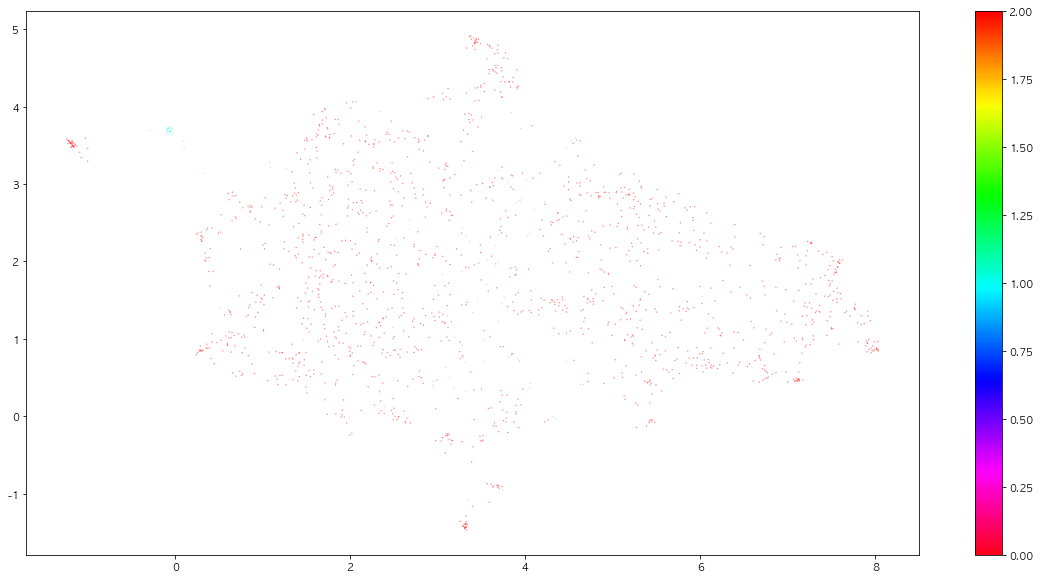

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [30]:
docs_df = pd.DataFrame(full_text, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [33]:
docs_df[docs_df['Topic']==1]

,Doc,Topic,Doc_ID
41,이 세 군단의 전위 부대는 꼭같은 시간에 시청 앞 광장에서 합류했다,1,41
106,세 사람 모두 비슷한 사정인 듯 속에 품은 계획까지 같았다,1,106
133,조금 전의 그 세 사나이는 각기 아내를 안쪽에 자리잡아 앉히고 나서 자기들도 올라탔다,1,133
220,그러나 곧 세 부인 사이에서는 대화가 다시 시작됐다,1,220
224,세 사람의 남편들 역시 같았다,1,224
231,이리하여 세 사람은 재빨리 친근감이 깃든 시선을 주고 받았다,1,231
234,그 동안 남자들은 세 번이나 차에서 내렸다,1,234
273,마침내 세 시가 되었다,1,273
634,근심스러워진 세 사람은 서둘러 되돌아왔다,1,634
676,2층으로 올라간 세 사람은 이 여관에서 제일 좋은 방으로 안내되었 다,1,676


In [34]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [35]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
3,2,1494
0,-1,99
1,0,33
2,1,19


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)


,Topic,Size
0,-1,1645
